In [24]:
import openml
import pandas as pd
import numpy as np
import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import time
import psutil
import warnings
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_percentage_error, roc_curve, roc_auc_score


In [2]:
dataset = openml.datasets.get_dataset(31)

X, y, categorical_indicator, attribute_names = dataset.get_data(target=dataset.default_target_attribute, dataset_format='dataframe')


categorical_columns = [i for i, indicator in enumerate(categorical_indicator) if indicator]

In [3]:
le = LabelEncoder()
y = le.fit_transform(y)
for col in categorical_columns:
    X.iloc[:, col] = le.fit_transform(X.iloc[:, col])

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### test model

In [31]:
time_cost = []
memory_cost = []

In [32]:
lgbm_model = lgb.LGBMClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42)

start_time = time.time()

lgbm_model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2  # in megabytes
print("Memory Usage:", memory_usage, "MB")

time_cost.append(elapsed_time)
memory_cost.append(memory_usage)

lgbm_accuracy = lgbm_model.score(X_test, y_test)
print("Accuracy:", lgbm_accuracy)

Elapsed Time: 0.040111541748046875
Memory Usage: 241.5859375 MB
Accuracy: 0.785


In [33]:
catboost_model = cb.CatBoostClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42,verbose=False)

start_time = time.time()

catboost_model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2  # in megabytes
print("Memory Usage:", memory_usage, "MB")

time_cost.append(elapsed_time)
memory_cost.append(memory_usage)

catboost_accuracy = catboost_model.score(X_test, y_test)
print("CatBoost Accuracy:", catboost_accuracy)


Elapsed Time: 0.19858241081237793
Memory Usage: 243.24609375 MB
CatBoost Accuracy: 0.805


In [34]:
xgboost_model = xgb.XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=6,random_state=42)

start_time = time.time()

xgboost_model.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2  # in megabytes
print("Memory Usage:", memory_usage, "MB")

time_cost.append(elapsed_time)
memory_cost.append(memory_usage)

xgboost_accuracy = xgboost_model.score(X_test, y_test)
print("XGBoost Accuracy:", xgboost_accuracy)

Elapsed Time: 0.0861501693725586
Memory Usage: 244.625 MB
XGBoost Accuracy: 0.775


In [36]:
print(time_cost)

print(memory_cost)

[0.040111541748046875, 0.19858241081237793, 0.0861501693725586]
[241.5859375, 243.24609375, 244.625]


### more detailed


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.56      0.62        59
           1       0.83      0.90      0.86       141

    accuracy                           0.80       200
   macro avg       0.77      0.73      0.74       200
weighted avg       0.79      0.80      0.79       200



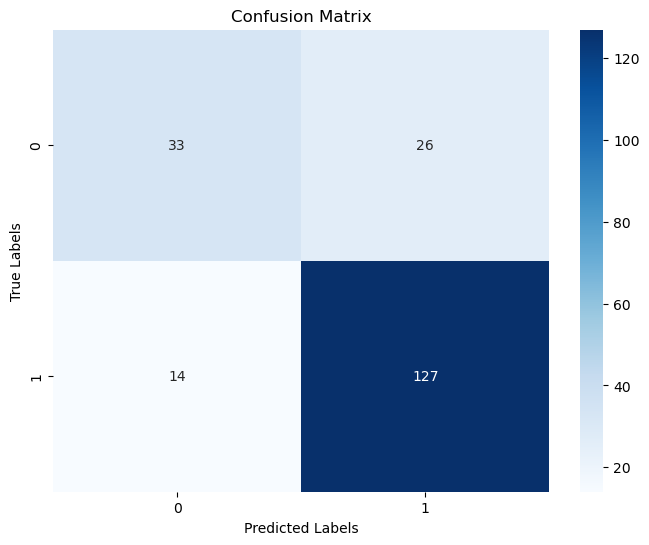

In [11]:
y_pred_lgbm = lgbm_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

class_labels = np.unique(np.concatenate((y_test, y_pred_lgbm)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.51      0.61        59
           1       0.82      0.93      0.87       141

    accuracy                           0.81       200
   macro avg       0.78      0.72      0.74       200
weighted avg       0.80      0.81      0.79       200



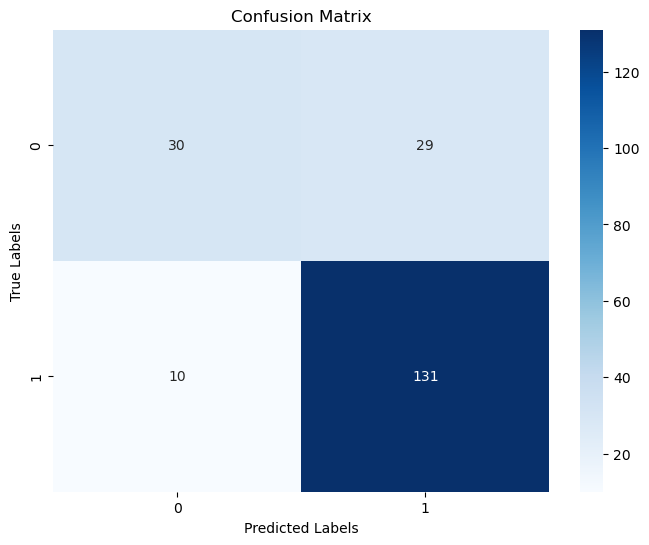

In [12]:
y_pred_cat = catboost_model.predict(X_test)

y_pred_cat = y_pred_cat.flatten()

print("Classification Report:")
print(classification_report(y_test, y_pred_cat))

class_labels = np.unique(np.concatenate((y_test, y_pred_cat)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_cat), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.63      0.69        59
           1       0.86      0.92      0.89       141

    accuracy                           0.83       200
   macro avg       0.81      0.77      0.79       200
weighted avg       0.83      0.83      0.83       200



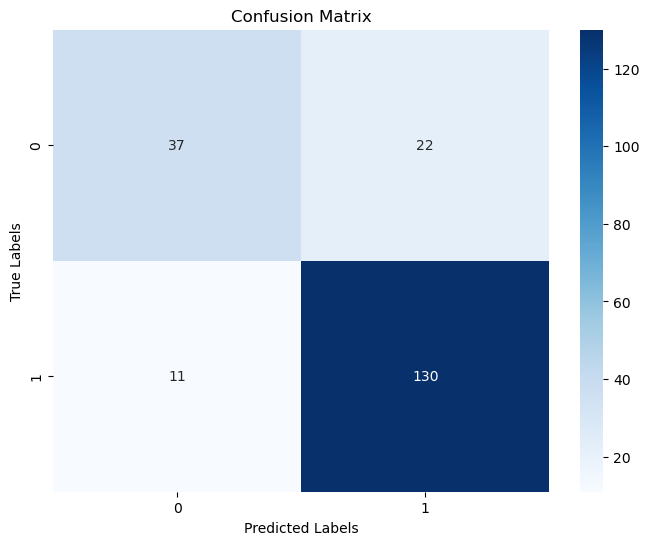

In [13]:
y_pred_xgb = xgboost_model.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))

class_labels = np.unique(np.concatenate((y_test, y_pred_xgb)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

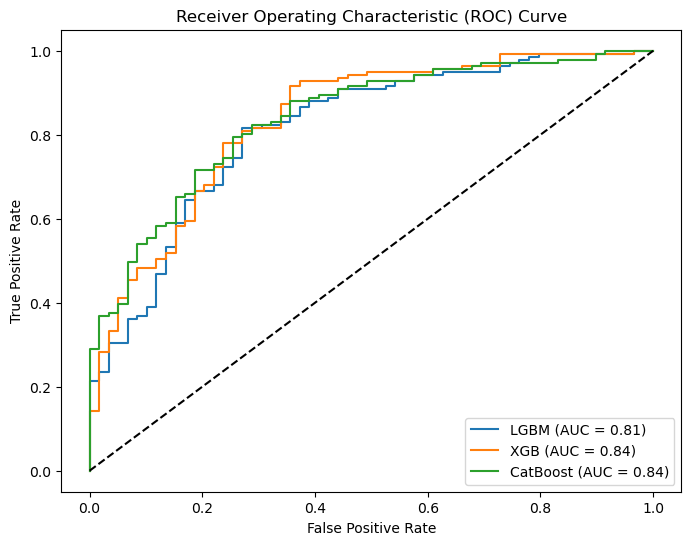

In [14]:
y_pred_proba_lgbm = lgbm_model.predict_proba(X_test)[:, 1]
y_pred_proba_xgb = xgboost_model.predict_proba(X_test)[:, 1]
y_pred_proba_cat = catboost_model.predict_proba(X_test)[:, 1]

fpr_lgbm, tpr_lgbm, thresholds_lgbm = roc_curve(y_test, y_pred_proba_lgbm)
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_proba_xgb)
fpr_cat, tpr_cat, thresholds_cat = roc_curve(y_test, y_pred_proba_cat)

auc_lgbm = roc_auc_score(y_test, y_pred_proba_lgbm)
auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
auc_cat = roc_auc_score(y_test, y_pred_proba_cat)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lgbm, tpr_lgbm, label='LGBM (AUC = {:.2f})'.format(auc_lgbm))
plt.plot(fpr_xgb, tpr_xgb, label='XGB (AUC = {:.2f})'.format(auc_xgb))
plt.plot(fpr_cat, tpr_cat, label='CatBoost (AUC = {:.2f})'.format(auc_cat))
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [27]:
logreg = LogisticRegression()

warnings.filterwarnings("ignore")

start_time = time.time()

logreg.fit(X_train, y_train)

elapsed_time = time.time() - start_time
print("Elapsed Time:", elapsed_time)

memory_usage = psutil.Process().memory_info().rss / 1024**2  # in megabytes
print("Memory Usage:", memory_usage, "MB")

logreg_accuracy = logreg.score(X_test, y_test)
print("logreg Accuracy:", logreg_accuracy)

Elapsed Time: 0.0188753604888916
Memory Usage: 126.4609375 MB
logreg Accuracy: 0.73


Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.31      0.40        59
           1       0.76      0.91      0.83       141

    accuracy                           0.73       200
   macro avg       0.67      0.61      0.61       200
weighted avg       0.71      0.73      0.70       200



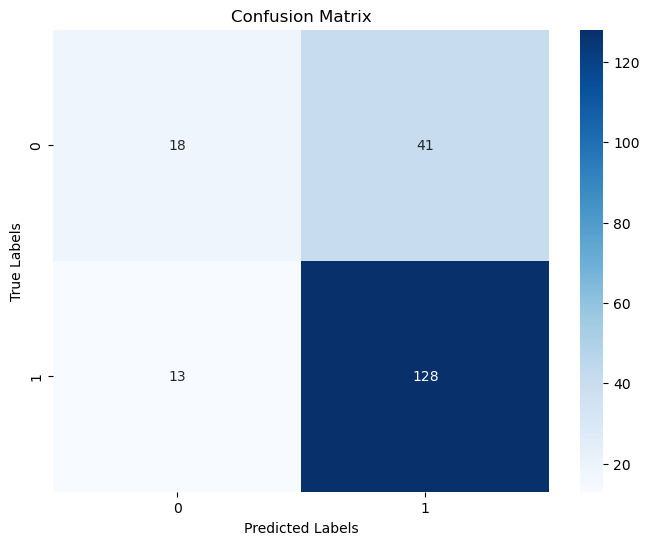

In [28]:
log_pred = logreg.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, log_pred))

class_labels = np.unique(np.concatenate((y_test, log_pred)))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, log_pred), annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()